In [1]:
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score, contextual_precision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from output_utils.utils import plot
from supporting_func.supporting_func import convert_dftimetodate, time_segments_aggregate, time_segments_aggregate
from global_variables.global_variables import filename_train, all_activities, filename_test, filename_summary
from orion.primitives.tadgan import TadGAN

Using TensorFlow backend.


In [3]:
    
df = pd.read_csv(filename_train)
df = df[all_activities]
pickle_file = "sleep_model.pickle"

In [6]:
#here df is the given dataframe and "timestamp" is the required column to be altered.
X, index = time_segments_aggregate(df, interval=300, time_column='timestamp')
print(X)

In [27]:
#importing sklearn module
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

#Using the simple scikit imputer
imp = SimpleImputer()
X = imp.fit_transform(X)

In [28]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [29]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)
#the target value; the value at time t.
#previous observed values, this is determined by the window width.
X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=200, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [30]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (2659, 200, 1)
Training data index shape: (2659,)
Training y shape: (2659, 1)
Training y index shape: (2659,)


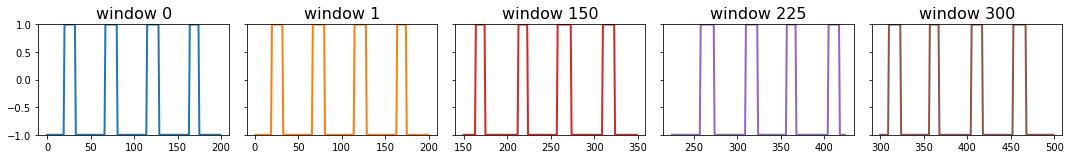

In [31]:
from output_utils.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts
#function from utils.py module. Representing all the windows that has been created by slicing
#Here X represents the input used to train the model. In the previous example, we see X has 10222 training data points.
#Notice that 100 represents the window size. On the other hand, y is the real signal after processing, 
#which we will use later on to calculate the error between the reconstructed and real signal.
plot_rws(X, 200)

In [33]:
from config.model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 10
hyperparameters["input_shape"] = (200, 1)
hyperparameters["target_shape"] = (200, 1) 
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64
hyperparameters["layers_generator"][1]["parameters"]["units"] = int(200/2)

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2022-08-07 12:14:10.796078: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-08-07 12:14:10.878873: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f93f65be5e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-07 12:14:10.879183: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2022-08-07 12:14:43.623241: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-08-07 12:14:43.656112: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iter

Epoch: 1/10, [Dx loss: [ -9.827838   -15.552927     1.0867207    0.46383682]] [Dz loss: [ 4.414114   -0.72043204  4.0120277   0.11225178]] [G loss: [ 5.1563196 -1.0462426 -2.9732604  0.9175822]]
Epoch: 2/10, [Dx loss: [-11.684389  -19.210564    4.862583    0.2663589]] [Dz loss: [-11.853525   -1.5090872 -17.961422    0.7616989]] [G loss: [26.885803   -4.65536    23.735336    0.78058267]]
Epoch: 3/10, [Dx loss: [ -6.9339666  -16.64059      8.632631     0.10739919]] [Dz loss: [-1.228622    0.08216685 -3.7164028   0.24056141]] [G loss: [ 3.0453415 -8.321149   5.323396   0.6043093]]
Epoch: 4/10, [Dx loss: [ -5.057601   -10.537653     4.7022614    0.07777915]] [Dz loss: [-4.302628    1.5496479  -7.1875014   0.13352266]] [G loss: [ 9.4897785 -4.2301774  9.347492   0.4372463]]
Epoch: 5/10, [Dx loss: [-3.3576164  -6.838809    3.0696845   0.04115102]] [Dz loss: [-4.553747    1.9318966  -7.2373734   0.07517308]] [G loss: [ 8.394998   -2.7279193   8.172237    0.29506797]]
Epoch: 6/10, [Dx loss: [-

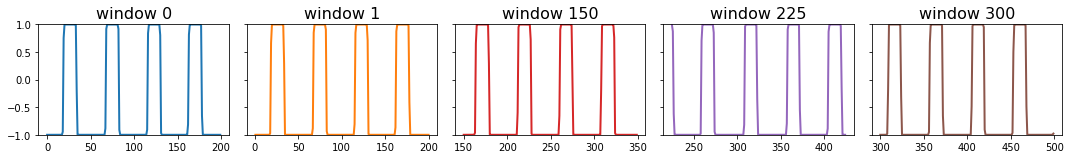

In [35]:
# reconstructing the signal
X_hat, critic = tgan.predict(X)
# visualize X_hat
plot_rws(X_hat, window=200)

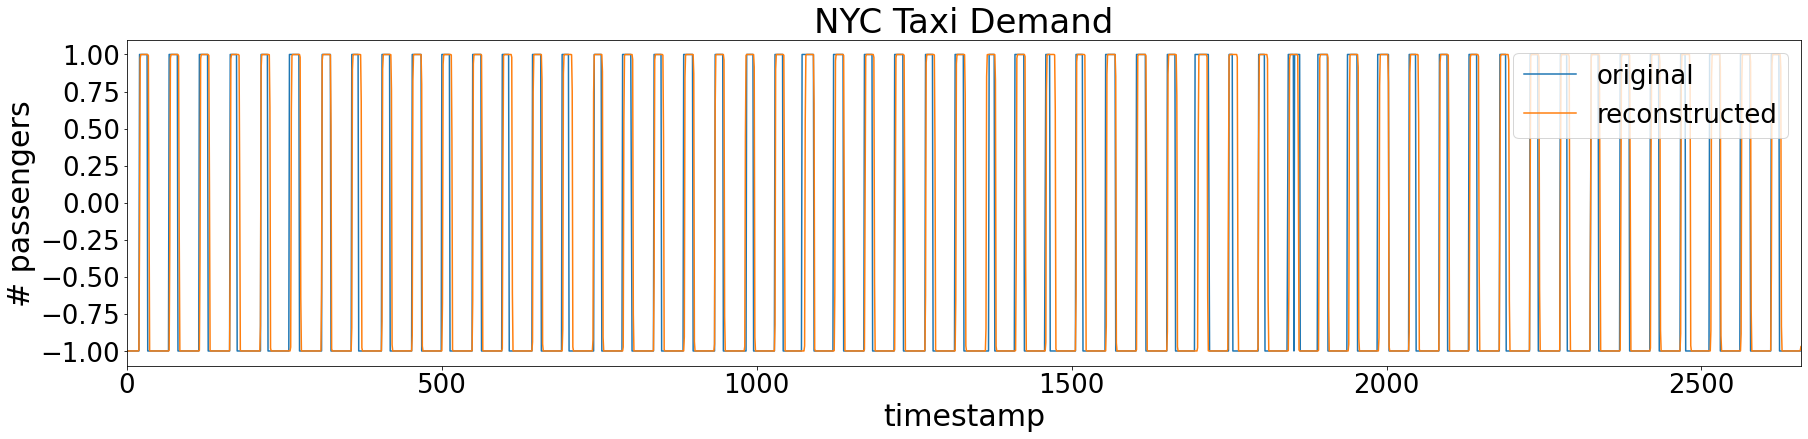

In [36]:
# flatten the predicted windows 
y_hat = unroll_ts(X_hat)
# plot the time series data 
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

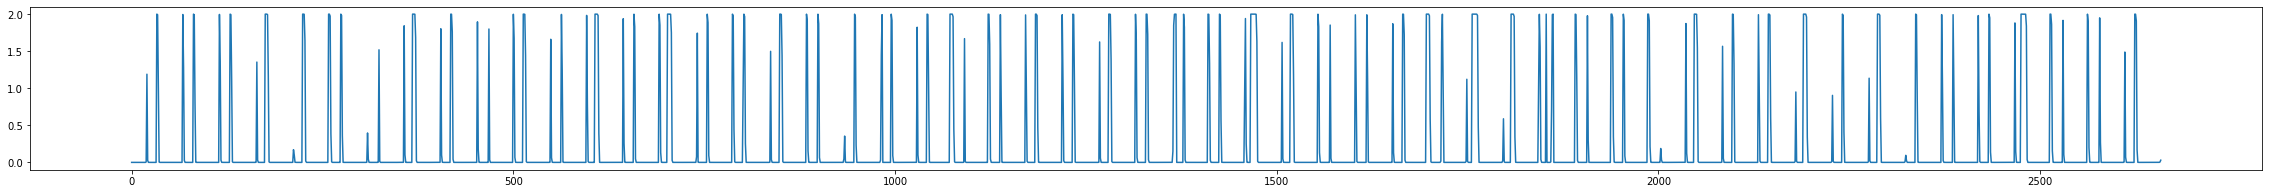

In [51]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(40, 3))
plt.plot(error)
plt.show()

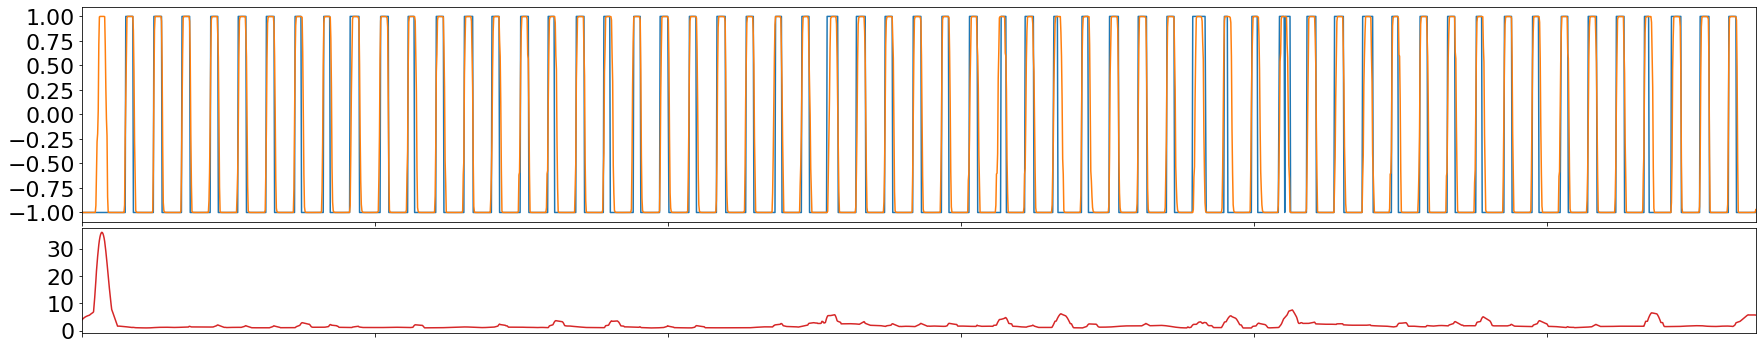

In [38]:
from orion.primitives.tadgan import score_anomalies
error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)
# visualize the error curve
plot_error([[true, pred], error])

In [45]:
# threshold to classify the high peak data points as anomolous points
thresh = 5

intervals = list()
print(error.shape)

i = 0
max_start = len(error)
print(max_start)
while i < max_start:
    j = i
    start = index[i]
    while (i < max_start) and (error[i] > thresh):
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

(2858,)
2858


[(49320, 139320, 17.357337420684264),
 (2328120, 2356920, 5.501317453563752),
 (3039120, 3066120, 5.6520529648252325),
 (3562920, 3575520, 5.23114638105112),
 (3735720, 3771720, 6.425850509012832),
 (4342320, 4345920, 5.043711066063942),
 (4853520, 4884120, 6.03277854950136),
 (5148720, 5182920, 5.706637060189639)]

                start                 end      score
0 2012-07-20 13:42:00 2012-07-21 14:42:00  17.357337
1 2012-08-15 22:42:00 2012-08-16 06:42:00   5.501317
2 2012-08-24 04:12:00 2012-08-24 11:42:00   5.652053
3 2012-08-30 05:42:00 2012-08-30 09:12:00   5.231146
4 2012-09-01 05:42:00 2012-09-01 15:42:00   6.425851
5 2012-09-08 06:12:00 2012-09-08 07:12:00   5.043711
6 2012-09-14 04:12:00 2012-09-14 12:42:00   6.032779
7 2012-09-17 14:12:00 2012-09-17 23:42:00   5.706637


TypeError: an integer is required (got type Timestamp)

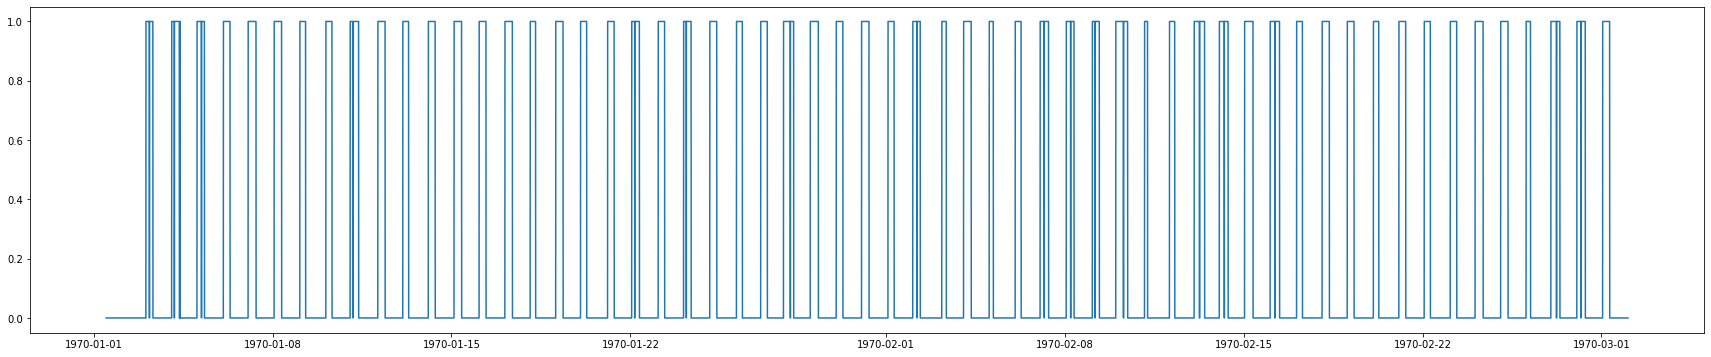

In [50]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
convert_dftimetodate(anomalies)
print(anomalies)
#now plotting the actual data, known anomalies and predicted anomalies
plot(df, [anomalies])